In [1]:
#Wymagania
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model, preprocessing, svm
from sklearn.preprocessing import StandardScaler, Normalizer
import math
import matplotlib
import seaborn as sns
from pandas.plotting import scatter_matrix
%matplotlib inline
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score


In [2]:

#Ładowanie danych
path = r'C:\Users\Wietczak\Desktop\autos.csv'
data = pd.read_csv(path, encoding='Latin1', sep=',')



In [3]:
#Czyszczenie danych
data.drop(['seller', 'offerType', 'abtest', 'dateCrawled', 
         'nrOfPictures', 'lastSeen', 'postalCode', 'dateCreated'], axis='columns', inplace=True)


In [4]:
print("Too new: %d" % data.loc[data.yearOfRegistration >= 2017].count()['name'])
print("Too old: %d" % data.loc[data.yearOfRegistration < 1950].count()['name'])
print("Too cheap: %d" % data.loc[data.price < 100].count()['name'])
print("Too expensive: " , data.loc[data.price > 150000].count()['name'])
print("Too few km: " , data.loc[data.kilometer < 5000].count()['name'])
print("Too many km: " , data.loc[data.kilometer > 200000].count()['name'])
print("Too few PS: " , data.loc[data.powerPS < 10].count()['name'])
print("Too many PS: " , data.loc[data.powerPS > 500].count()['name'])
print("Fuel types: " , data['fuelType'].unique())
print("Damages: " , data['notRepairedDamage'].unique())
print("Vehicle types: " , data['vehicleType'].unique())
print("Brands: " , data['brand'].unique())



#### Usuwaie duplikatow
dedups = data.drop_duplicates(['name','price','vehicleType','yearOfRegistration'
                         ,'gearbox','powerPS','model','kilometer','monthOfRegistration','fuelType'
                         ,'notRepairedDamage'])

#### Usuwanie outlierow
dedups = dedups[
        (dedups.yearOfRegistration <= 2016) 
      & (dedups.yearOfRegistration >= 1950) 
      & (dedups.price >= 100) 
      & (dedups.price <= 150000) 
      & (dedups.powerPS >= 10) 
      & (dedups.powerPS <= 500)]



Too new: 14680
Too old: 289
Too cheap: 13320
Too expensive:  232
Too few km:  0
Too many km:  0
Too few PS:  41040
Too many PS:  835
Fuel types:  ['benzin' 'diesel' nan 'lpg' 'andere' 'hybrid' 'cng' 'elektro']
Damages:  [nan 'ja' 'nein']
Vehicle types:  [nan 'coupe' 'suv' 'kleinwagen' 'limousine' 'cabrio' 'bus' 'kombi'
 'andere']
Brands:  ['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'porsche' 'toyota' 'chevrolet'
 'dacia' 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'rover'
 'land_rover' 'lada']


In [5]:
dedups['notRepairedDamage'].fillna(value='not-declared', inplace=True)
dedups['fuelType'].fillna(value='not-declared', inplace=True)
dedups['gearbox'].fillna(value='not-declared', inplace=True)
dedups['vehicleType'].fillna(value='not-declared', inplace=True)
dedups['model'].fillna(value='not-declared', inplace=True)

In [6]:
#Sprawdzanie procesu deduplikacji
dedups.isnull().sum()

name                   0
price                  0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
dtype: int64

gearbox
manuell         231997
automatik        66876
not-declared      5260
Name: gearbox, dtype: int64


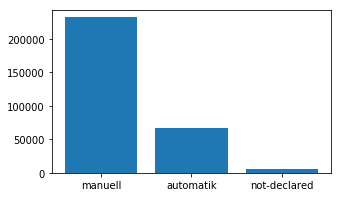

model
golf            24846
andere          21733
3er             17704
not-declared    11347
polo            10477
Name: model, dtype: int64


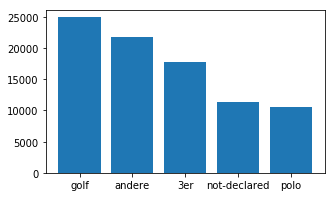

brand
volkswagen       64853
bmw              34441
opel             31757
mercedes_benz    29562
audi             27984
Name: brand, dtype: int64


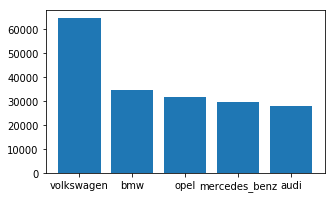

vehicleType
limousine     84843
kleinwagen    68415
kombi         59863
bus           26986
cabrio        20921
Name: vehicleType, dtype: int64


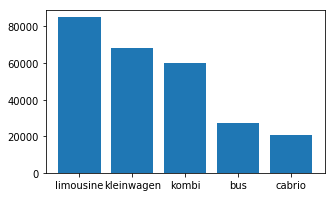

fuelType
benzin          189919
diesel           93299
not-declared     15400
lpg               4646
cng                474
Name: fuelType, dtype: int64


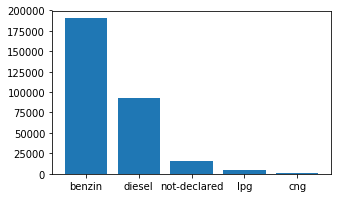

notRepairedDamage
nein            233684
not-declared     42124
ja               28325
Name: notRepairedDamage, dtype: int64


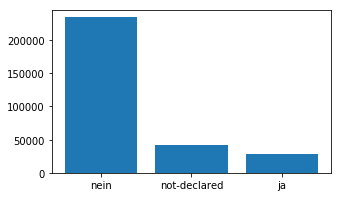

In [7]:
#Statystyki opisowe (wizualizacja)
categories = ['gearbox', 'model', 'brand', 'vehicleType', 'fuelType', 'notRepairedDamage']

for i, c in enumerate(categories):
    v = dedups[c].unique()
    
    g = dedups.groupby(by=c)[c].count().sort_values(ascending=False)
    r = range(min(len(v), 5))

    print( g.head())
    plt.figure(figsize=(5,3))
    plt.bar(r, g.head()) 
    #plt.xticks(r, v)
    plt.xticks(r, g.index)
    plt.show()

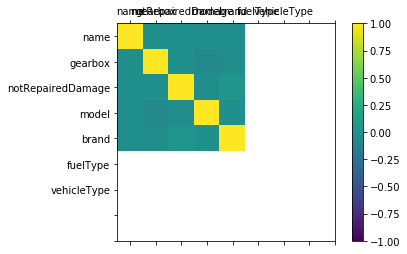

In [8]:
#Korelacje
names = ['name', 'gearbox', 'notRepairedDamage', 'model', 'brand', 'fuelType', 'vehicleType']
correlations = data.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()


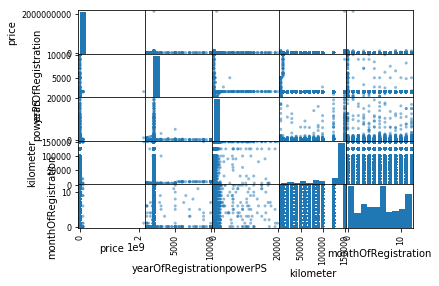

In [9]:
#Scatter matrix


scatter_matrix(data)
plt.show()

In [10]:
labels = ['name', 'gearbox', 'notRepairedDamage', 'model', 'brand', 'fuelType', 'vehicleType']
les = {}

for l in labels:
    les[l] = preprocessing.LabelEncoder()
    les[l].fit(dedups[l])
    tr = les[l].transform(dedups[l]) 
    dedups.loc[:, l + '_feat'] = pd.Series(tr, index=dedups.index)

labeled = dedups[ ['price'
                        ,'yearOfRegistration'
                        ,'powerPS'
                        ,'kilometer'
                        ,'monthOfRegistration'
                        ] 
                    + [x+"_feat" for x in labels]]

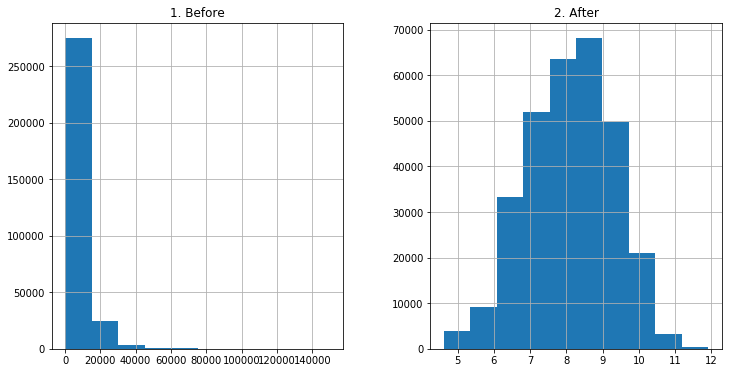

In [11]:
#Preprocessowanie danych
Y = labeled['price']
X = labeled.drop(['price'], axis='columns', inplace=False)


matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"1. Before":Y, "2. After":np.log1p(Y)})
prices.hist()

Y = np.log1p(Y)

In [12]:
#Import istotnnych funkcji oraz podział na zbiór testowy oraz treningowy
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score, train_test_split


def cv_rmse(model, x, y):
    r = np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = 5))
    return r

# Procent uzywanych danych na trening
test_size = .2

#Podzial na zbior treningowy i walidacyjny
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state = 3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

r = range(2003, 2017)
km_year = 10000

(243306, 11) (60827, 11) (243306,) (60827,)


In [13]:
# Tworzenie regressora liniowego
regr = linear_model.LinearRegression()

# Trenowanie modelu
regr.fit(X_train, y_train)

# Predykcja
y_pred = regr.predict(X_test)

# Wspolczynniki
print('Coefficients: \n', regr.coef_)
# Bład sredniokwadratowy
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Score 
print('Variance score: %.2f' % r2_score(y_test, y_pred))



Coefficients: 
 [ 5.47556352e-02  9.74346603e-03 -8.98619427e-06  1.79110772e-02
 -3.91248158e-07 -1.41183505e-01  1.06222880e-01 -4.04743841e-04
  5.73370510e-03  2.12952743e-02 -6.42785907e-02]
Mean squared error: 0.58
Variance score: 0.59


In [ ]:
#Metoda wektorów nośnych (SVM)
#Tworzenie regressora SVM
model = svm.SVR( C=1, epsilon = 0.2) 
#Proces modelowania

model.fit(X_train, y_train)
model.score(X_train, y_train)
#Predict Output
predicted= model.predict(x_test)

In [22]:
# Siec neuronowa 
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=0.001,
                  hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train, y_train)
y_pred = nn.predict(X_test)